### Deep Efficient (Partial) Hedging


Payoff to hedge: $Z$

Wealth process with transaction cost:
$$
V_T = V_0 + (H\cdot S)_T - C_T.
$$
Given $V_0$, find the best strategy $H$ that minimize
$$
\mathbb{E}[\ell ((Z-V_T)_+)]
$$
where $Z$ is the payoff and $\ell(x) = \frac{x^{p}}{p},\quad p > 0$.

We numerically minimize the loss consisting of three terms
\begin{equation}
    \mathcal{L}(K) = \mathcal{L}_{p}(K) + \mathcal{L}_{\text{cost}}(K) + \mathcal{L}_{\text{ad}}(K),
\end{equation}
where 
\begin{equation*}
\begin{aligned}
    \mathcal{L}_{p}(K) &= \mathbb{E}\Big[\ell ((Z-V_T)_+) \Big],\\
    \mathcal{L}_{\text{cost}}(K) &= c_{\text{cost}}\mathbb{E}\Big[\sum_{t=1}^{T-1}\lvert H_{t+1} - H_{t}\rvert \cdot S_{t}\Big],\\
    \mathcal{L}_{\text{ad}}(K) &= c_{\text{ad}}\mathbb{E}\Big[(-\min_{t}V_{t})_{+}\Big],
\end{aligned}
\end{equation*}

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from os import makedirs
from neuralhedge.nn import datahedger, mlp, loss, blackschole
from neuralhedge.nn.loss import EntropicRiskMeasure, SquareMeasure, ExpectedShortfall, admissible_cost
from neuralhedge._utils.plotting import plot_pnl, plot_history, plot_data, plot_hedge
from neuralhedge.data.stochastic import BlackScholesDataset, simulate_time
from neuralhedge.nn.contigent import EuropeanVanilla
from neuralhedge.nn.efficienthedger import EfficientHedger

In [2]:
n_sample = 50000
n_timestep = 30*5
dt = 1/365/5

ds_bs = BlackScholesDataset(n_sample = n_sample,
                          n_timestep = n_timestep,
                          dt = dt)
paths = ds_bs.paths*100


contigent = EuropeanVanilla(strike = 100., call = True)
payoff = contigent.payoff(paths[:,-1,0])

info1 = torch.log(paths)
info2 = simulate_time(n_sample, dt, n_timestep, reverse = True)
info = torch.cat([info1,
                  info2],
                  dim = -1)
data = [paths, info, payoff]

Shape of paths:  torch.Size([50000, 151, 1])
Shape of information:  torch.Size([50000, 151, 2])
Shape of payoff:  torch.Size([50000])


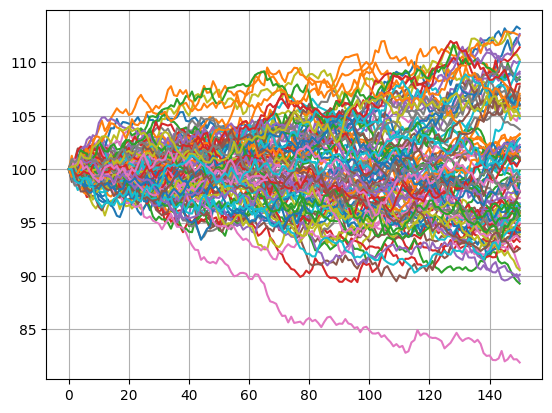

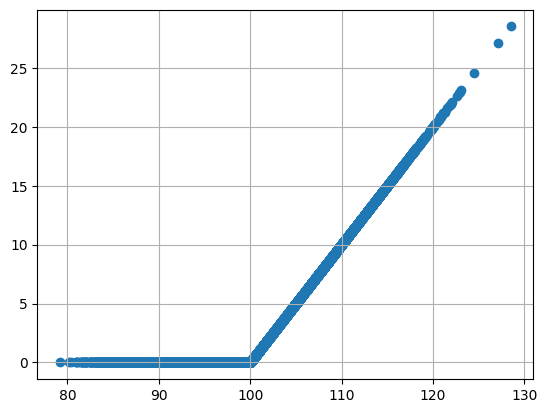

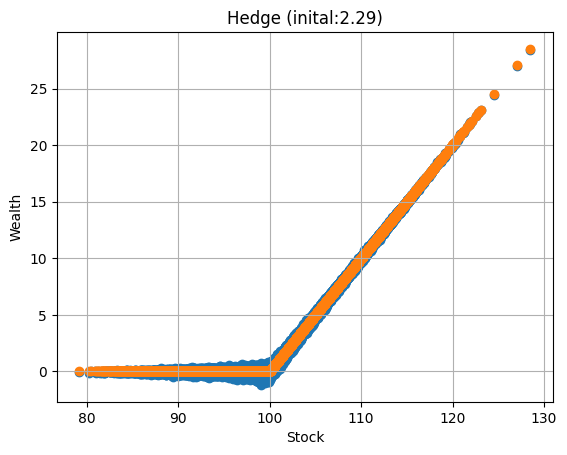

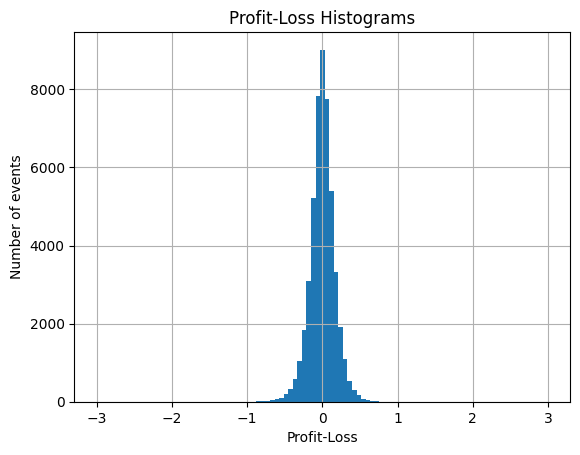

In [3]:
data = [paths, info, payoff]
hedge_ds = datahedger.HedgerDataset(data)
model_delta = blackschole.BlackScholesDelta(sigma = ds_bs.sigma,
                                      risk_free_rate = 0.,
                                      strike = contigent.strike)
bs_pricer = blackschole.BlackScholesPrice(sigma = ds_bs.sigma,
                                      risk_free_rate = 0.,
                                      strike = contigent.strike)
bs_price = bs_pricer(info[0,0])[0]
hedger = EfficientHedger(model_delta) 

plot_data(data)
plot_hedge(hedger, hedge_ds.data, init_wealth=bs_price)

/Users/hous/Documents/GitHub/NeuralHedge/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=0.3783476948738098: 100%|██████████| 50/50 [08:19<00:00,  9.99s/it] 


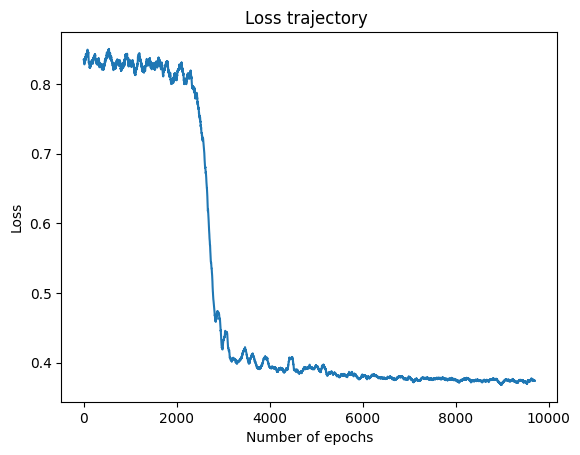

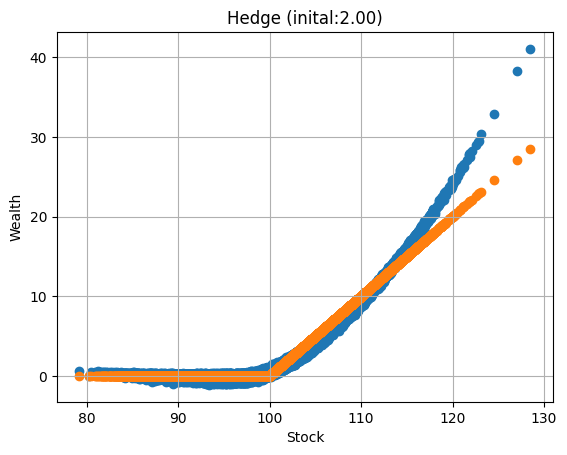

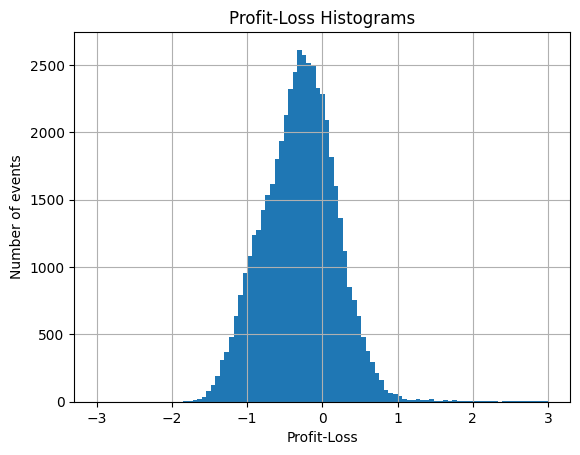

/Users/hous/Documents/GitHub/NeuralHedge/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Average admissibility break: 0.14


Loss=0.2191523313522339: 100%|██████████| 50/50 [07:34<00:00,  9.09s/it] 


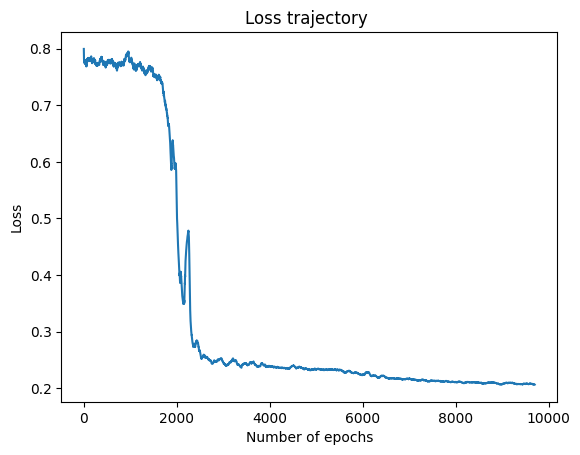

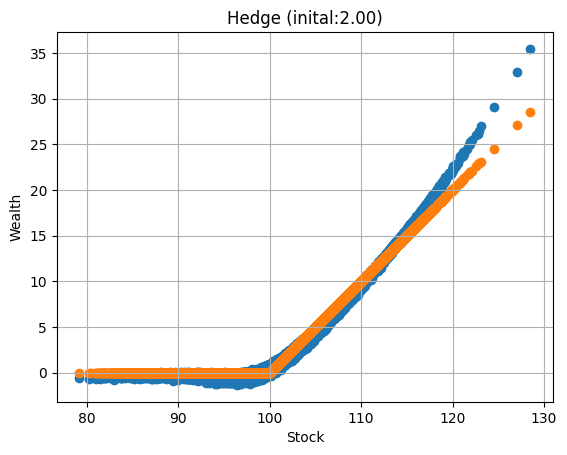

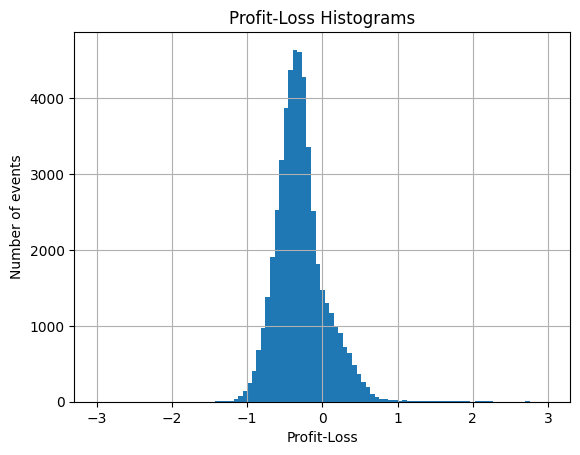

Average admissibility break: 0.21


Loss=0.44573238492012024: 100%|██████████| 50/50 [07:31<00:00,  9.03s/it]


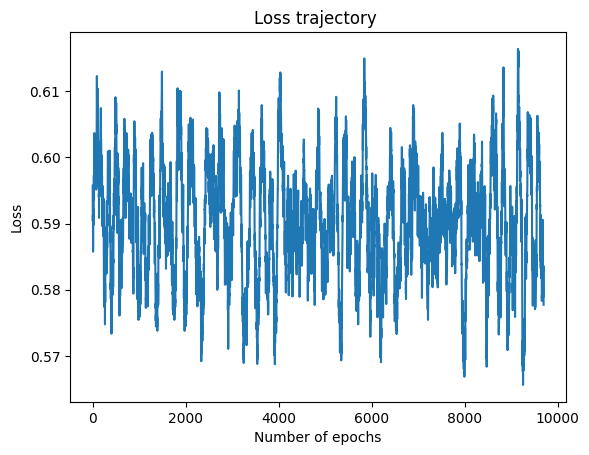

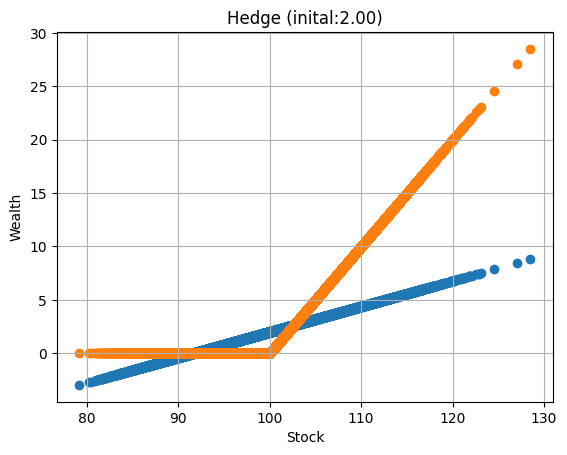

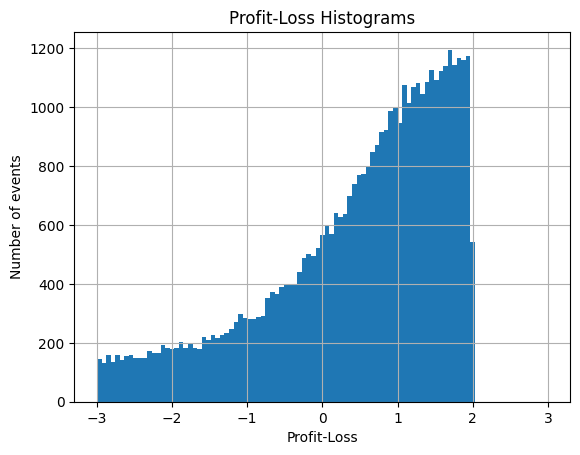

Average admissibility break: 0.07


In [4]:
EPOCHS = 50
initial_price = 2.0
admissible_bound = -5
for p in [1,2,0.5]:

    print('='*20)
    print('p: ', p)


    record_dir = None
    # record_dir = './examples/numerical_results/bs_call_efficient_' + str(p) + '/'
    # makedirs(record_dir, exist_ok=True)

    model = mlp.NeuralNetSequential(n_output = paths.shape[-1])
    hedger = EfficientHedger(model, initial_price, admissible_bound) 
    hedger.fit(hedge_ds, EPOCHS=EPOCHS, risk=loss.PowerMeasure(p), record_dir=record_dir) 

    price = torch.tensor(initial_price)
    plot_history(hedger.history, record_dir = record_dir)
    plot_hedge(hedger, data, price, record_dir = record_dir)

    with torch.no_grad():
        wealth = hedger(data)
        wealth_tensor = hedger.init_wealth + torch.stack(wealth,dim = 1)
        avg_ad = admissible_cost(wealth_tensor).numpy()
    print('Average admissibility break: {:.2f}'.format(avg_ad))
    print('='*20)